In [1]:
!pip install pyLDAvis

  Using cached pandas-2.1.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.3 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
bigframes 0.17.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.1.4 which is incompatible.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.1.4 which is incompatible.


In [2]:
pip install pandas==1.5.3

  Using cached pandas-1.5.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.1 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 2.1.4
    Uninstalling pandas-2.1.4:
      Successfully uninstalled pandas-2.1.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
pyldavis 3.4.1 requires pandas>=2.0.0, but you have pandas 1.5.3 which is incompatible.


## TOPIC MODELLING: Using LDA

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from numpy.linalg import ilp64
import seaborn as sns
import re
%matplotlib inline

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk import pos_tag
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.corpus import wordnet

# nltk.download('omw-1.4')
# nltk.download('averaged_perceptron_tagger')

# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [4]:
# To access Google Drive:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


### Loading Data

Loading label data

In [5]:
data = pd.read_csv('/content/gdrive/MyDrive/Copy of amazon_labeled_products.tsv', delimiter=',')


In [6]:
data.head()

,Unnamed: 0,asin,description,title,label
0,0,B000B5H26O,['Yorkshire Tea never compromise on the qualit...,"Taylors of Harrogate Yorkshire Gold Tea, 160 T...",1
1,1,B000F3WS7K,['We choose teas from our three favorite origi...,"Taylors of Harrogate Yorkshire Gold, 40 Teabag...",1
2,2,B000HRS7OM,"['Made with a blend of teas from Assam, Africa...","Taylors of Harrogate Yorkshire Red, 160 Teabags",1
3,3,B001E5DXY0,['We choose teas from our three favorite origi...,Taylors of Harrogate Yorkshire Gold Loose Leaf...,1
4,4,B004G90QE6,"['Made with a blend of teas from Assam, Africa...","Taylors of Harrogate Yorkshire Red, 240 Teabags",1


In [8]:
data.shape

(12326, 5)

**Loading review data**

In [7]:
# amazon_df = pd.read_json('Grocery_and_Gourmet_Food.json', encoding='utf-8')

import json

with open('/content/gdrive/MyDrive/Copy of Grocery_and_Gourmet_Food_5.json', 'r') as file:
    json_data = [json.loads(line) for line in file]
amazon_df = pd.DataFrame(json_data)

In [9]:
amazon_df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1VEELTKS8NLZB,616719923X,Amazon Customer,"[0, 0]",Just another flavor of Kit Kat but the taste i...,4.0,Good Taste,1370044800,"06 1, 2013"
1,A14R9XMZVJ6INB,616719923X,amf0001,"[0, 1]",I bought this on impulse and it comes from Jap...,3.0,"3.5 stars, sadly not as wonderful as I had hoped",1400457600,"05 19, 2014"
2,A27IQHDZFQFNGG,616719923X,Caitlin,"[3, 4]",Really good. Great gift for any fan of green t...,4.0,Yum!,1381190400,"10 8, 2013"
3,A31QY5TASILE89,616719923X,DebraDownSth,"[0, 0]","I had never had it before, was curious to see ...",5.0,Unexpected flavor meld,1369008000,"05 20, 2013"
4,A2LWK003FFMCI5,616719923X,Diana X.,"[1, 2]",I've been looking forward to trying these afte...,4.0,"Not a very strong tea flavor, but still yummy ...",1369526400,"05 26, 2013"


In [10]:
amazon_df.shape

(151254, 9)

**Filtering review data according to the product id present in the label data**

In [11]:
prod_id = data['asin'].unique().tolist()

In [12]:
amazon_df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1VEELTKS8NLZB,616719923X,Amazon Customer,"[0, 0]",Just another flavor of Kit Kat but the taste i...,4.0,Good Taste,1370044800,"06 1, 2013"
1,A14R9XMZVJ6INB,616719923X,amf0001,"[0, 1]",I bought this on impulse and it comes from Jap...,3.0,"3.5 stars, sadly not as wonderful as I had hoped",1400457600,"05 19, 2014"
2,A27IQHDZFQFNGG,616719923X,Caitlin,"[3, 4]",Really good. Great gift for any fan of green t...,4.0,Yum!,1381190400,"10 8, 2013"
3,A31QY5TASILE89,616719923X,DebraDownSth,"[0, 0]","I had never had it before, was curious to see ...",5.0,Unexpected flavor meld,1369008000,"05 20, 2013"
4,A2LWK003FFMCI5,616719923X,Diana X.,"[1, 2]",I've been looking forward to trying these afte...,4.0,"Not a very strong tea flavor, but still yummy ...",1369526400,"05 26, 2013"


In [13]:
amazon_df.shape

(151254, 9)

**Filtering review data according to the product id present in the label data**

In [14]:
prod_id = data['asin'].unique().tolist()

In [15]:
prod_review_df = amazon_df[amazon_df['asin'].isin(prod_id)]

In [16]:
prod_review_df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
251,A1AGHOOHRDUYDW,B0000DI085,A. McKee,"[0, 0]",I love almond flavored desserts and knowing th...,5.0,Delicious for a variety of desserts,1379635200,"09 20, 2013"
252,A2EJCD6CRW8D8O,B0000DI085,"Ayemen ""Hannah Christian""","[1, 1]",This product arrived in good condition and it ...,5.0,A healthy way to flavour,1395705600,"03 25, 2014"
253,A1BE0JR188OFQQ,B0000DI085,Bubbas Mommie,"[0, 0]",Very pleased with the quality of this extract ...,5.0,Delicious flavor and no aftertaste,1391644800,"02 6, 2014"
254,A3KZ49CG0MBPU1,B0000DI085,"Gretchen CLS ""Lynn""","[0, 0]",I use almond extract in many family recipes. T...,5.0,Excellent product from an excellent Brand!,1403049600,"06 18, 2014"
255,AQM4E3PJI2S7J,B0000DI085,Jeff Laviletta,"[1, 1]",I needed this to make my mother-in-law's pound...,5.0,Tastes great,1392940800,"02 21, 2014"


In [17]:
prod_review_df.shape

(7922, 9)

**merging product label data and review data**

In [18]:
prod_review_df = prod_review_df[['asin','reviewText']]

In [19]:
PR_df = pd.merge(prod_review_df,data, on = ['asin'], how='inner')




**Preparing Bag of reviews for each product id**

In [20]:
review_bag = pd.DataFrame(PR_df.groupby('asin')['reviewText'].apply(list))
review_bag.reset_index(inplace=True)

In [21]:
aa = pd.DataFrame(PR_df.groupby('asin').mean().round()['label'])
aa.reset_index(inplace=True)

<ipython-input-21-0a4ea6eb7047>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aa = pd.DataFrame(PR_df.groupby('asin').mean().round()['label'])


In [22]:
final_df = pd.merge(review_bag,aa, on=['asin'])

In [23]:
final_df

,asin,reviewText,label
0,B0000DI085,[I love almond flavored desserts and knowing t...,1.0
1,B0001590IC,[I love this tea. It has a nice robust flavor ...,1.0
2,B0005ZX5PM,[This is standard against which I compare all ...,0.0
3,B0007KLJEE,"[very good and it's organic, I WANTED ORGANIC ...",1.0
4,B00099XOVO,"[I like this rice, it's nice and cheesy. The b...",0.0
...,...,...,...
360,B00DG00PJW,"[Like some other prior reviewers, I bought thi...",1.0
361,B00DRA8HWI,[I'm not going to discuss the gluten issues. ...,1.0
362,B00DRA8IFO,[I'm not going to write about the benefits of ...,1.0
363,B00DUQDIMI,[I got a chance to try out a box of this tea o...,0.0


In [24]:
df = final_df[['reviewText','label']]

In [25]:
df.head()

,reviewText,label
0,[I love almond flavored desserts and knowing t...,1.0
1,[I love this tea. It has a nice robust flavor ...,1.0
2,[This is standard against which I compare all ...,0.0
3,"[very good and it's organic, I WANTED ORGANIC ...",1.0
4,"[I like this rice, it's nice and cheesy. The b...",0.0


In [26]:
df.dtypes

reviewText     object
label         float64
dtype: object

In [27]:

df['reviewText']

0      [I love almond flavored desserts and knowing t...
1      [I love this tea. It has a nice robust flavor ...
2      [This is standard against which I compare all ...
3      [very good and it's organic, I WANTED ORGANIC ...
4      [I like this rice, it's nice and cheesy. The b...
                             ...                        
360    [Like some other prior reviewers, I bought thi...
361    [I'm not going to discuss the gluten issues.  ...
362    [I'm not going to write about the benefits of ...
363    [I got a chance to try out a box of this tea o...
364    [This is the first time I have used this sauce...
Name: reviewText, Length: 365, dtype: object

### **Remove punctuation/lower casing**

Next, let’s perform a simple preprocessing on the content of reviewtText column to make them more amenable for analysis, and reliable results. To do that, we’ll use a regular expression to remove any punctuation, and then lowercase the text

here we are considering the list of reviews as a  single document with multiple sentence.

In [28]:
import re

# Remove punctuation
df['reviewText_processed'] = df['reviewText'].map(lambda x: re.sub('[^A-Za-z]+', ' ', str(x)))

# Convert the titles to lowercase
df['reviewText_processed'] = df['reviewText_processed'].map(lambda x: x.lower())

# Print out the first rows of papers
df['reviewText_processed'].head()

0     i love almond flavored desserts and knowing t...
1     i love this tea it has a nice robust flavor t...
2     this is standard against which i compare all ...
3     very good and it s organic i wanted organic a...
4     i like this rice it s nice and cheesy the bro...
Name: reviewText_processed, dtype: object

### **Exploratory Analysis**
To verify whether the preprocessing, we’ll make a word cloud using the wordcloud package to get a visual representation of most common words. It is key to understanding the data and ensuring we are on the right track, and if any more preprocessing is necessary before training the model.

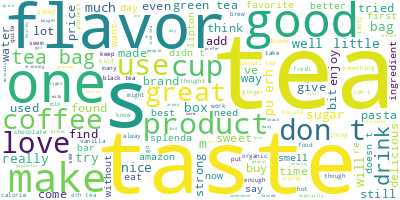

In [29]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(df['reviewText_processed'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

### **Prepare data for LDA Analysis**
Next, let’s work to transform the textual data in a format that will serve as an input for training LDA model. We start by tokenizing the text and removing stopwords. Next, we convert the tokenized object into a corpus and dictionary.

In [30]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc))
             if word not in stop_words] for doc in texts]

data = df['reviewText_processed'].values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['love', 'almond', 'flavored', 'desserts', 'knowing', 'organic', 'makes', 'feel', 'better', 'sometimes', 'substitute', 'vanilla', 'making', 'muffins', 'pancakes', 'baked', 'goods', 'even', 'used', 'smoothies', 'love', 'almond', 'flavored', 'desserts', 'knowing', 'organic', 'makes', 'feel', 'better', 'sometimes']


In [31]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 2), (1, 2), (2, 20), (3, 2), (4, 2), (5, 2), (6, 8), (7, 2), (8, 2), (9, 8), (10, 2), (11, 2), (12, 2), (13, 2), (14, 2), (15, 2), (16, 2), (17, 4), (18, 2), (19, 4), (20, 2), (21, 2), (22, 4), (23, 2), (24, 2), (25, 2), (26, 2), (27, 2), (28, 2), (29, 6)]


### **LDA model training**
Here i defined the function which iterate through range of different values of number of topic, chunk size and passses values to find the best number of topics

In [32]:
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora import Dictionary
import logging

In [33]:
# Experiment parameters
chunk_sizes = [1000, 2000, 3000]
passes_values = [10, 20] 
num_topics_range = range(2, 10) 

# Function to run experiments and find the optimal number of topics
def run_lda_experiments(corpus, id2word, texts):
    best_coherence = -1
    best_num_topics = 0
    best_lda_model = None

    for chunk_size in chunk_sizes:
        for passes in passes_values:
            for num_topics in num_topics_range:
                # Build LDA model
                lda_model = LdaModel(
                    corpus=corpus,
                    id2word=id2word,
                    num_topics=num_topics,
                    chunksize=chunk_size,
                    passes=passes
                )

                # Compute coherence score
                coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
                coherence_score = coherence_model.get_coherence()

                # Check for best coherence score
                if coherence_score > best_coherence:
                    best_coherence = coherence_score
                    best_num_topics = num_topics
                    best_lda_model = lda_model

    return best_lda_model, best_num_topics, best_coherence

# Run experiments
best_model, optimal_num_topics, best_coherence_score = run_lda_experiments(corpus, id2word, texts)

# Output results
print(f"Optimal number of topics (K): {optimal_num_topics}")
print(f"Best coherence score: {best_coherence_score}")

Optimal number of topics (K): 7
Best coherence score: 0.4587119458457411


### **Analyzing LDA model results**
Now that we have a trained model let’s visualize the topics for interpretability. To do so, we’ll use a popular visualization package, pyLDAvis which is designed to help interactively with:

Better understanding and interpreting individual topics, and
Better understanding the relationships between the topics.
For (1), you can manually select each topic to view its top most frequent and/or “relevant” terms, using different values of the λ parameter. This can help when you’re trying to assign a human interpretable name or “meaning” to each topic.

For (2), exploring the Intertopic Distance Plot can help you learn about how topics relate to each other, including potential higher-level structure between groups of topics.

In [56]:
import pyLDAvis.gensim
import pickle
import pyLDAvis
import os
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('/content/gdrive/MyDrive/ldavis_prepared_'+str(optimal_num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(best_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, '/content/gdrive/MyDrive/ldavis_prepared_'+ str(optimal_num_topics) +'.html')
LDAvis_prepared

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.100965  0.004717       1        1  24.176828
6      0.095326  0.018687       2        1  15.090389
5     -0.106420 -0.029681       3        1  14.698155
1     -0.127274 -0.007910       4        1  12.508493
4      0.082734  0.022101       5        1  11.663177
3      0.044825  0.095807       6        1  11.655804
2      0.111775 -0.103722       7        1  10.207152, topic_info=          Term          Freq         Total Category  logprob  loglift
250        tea  16510.000000  16510.000000  Default  30.0000  30.0000
889      pasta   1695.000000   1695.000000  Default  29.0000  29.0000
3718   splenda   1311.000000   1311.000000  Default  28.0000  28.0000
12185       pu   1309.000000   1309.000000  Default  27.0000  27.0000
11851      erh   1272.000000   1272.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
123       well    213.554711   1869.453011   Topic7  -5.5215   0.1126
99      really    221.733621   2601.144211   Topic7  -5.4840  -0.1801
75        much    206.287255   2107.242650   Topic7  -5.5562  -0.0418
6       better    201.161125   1471.956544   Topic7  -5.5813   0.2918
51         get    201.380951   2113.815040   Topic7  -5.5802  -0.0690

[566 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
269        1  0.178976           add
269        2  0.073696           add
269        3  0.123704           add
269        4  0.121950           add
269        5  0.262323           add
...      ...       ...           ...
718        7  0.087454         would
12480      3  0.899440  yamamotoyama
7158       6  0.966545    yummyearth
12484      1  0.028861        yunnan
12484      3  0.952428        yunnan

[1465 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 7, 6, 2, 5, 4, 3])

In [57]:
from gensim.models import CoherenceModel

# Calculate coherence score using UMass coherence
coherence_model_umass = CoherenceModel(model=best_model, corpus=corpus, dictionary=id2word, coherence='u_mass')
coherence_umass = coherence_model_umass.get_coherence()

print(f'Coherence Score (UMass): {coherence_umass}')

# Calculate coherence score using c_v coherence
coherence_model_cv = CoherenceModel(model=best_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_cv = coherence_model_cv.get_coherence()

print(f'Coherence Score (C_V): {coherence_cv}')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Coherence Score (UMass): -0.7681465333729187
Coherence Score (C_V): 0.4587119458457411


### **Finding the dominant topic in each review**

In [63]:
import pandas as pd
from gensim import corpora, models


# Create a dictionary and corpus
dictionary = corpora.Dictionary(data_words)
corpus = [dictionary.doc2bow(text) for text in data_words]

# Function to find the dominant topic for each review
def get_dominant_topic(lda_model, text, dictionary):
    # Get the topic probability distribution for the document
    bow = dictionary.doc2bow(text)
    topics = lda_model.get_document_topics(bow)

    # Find the topic with the highest contribution
    dominant_topic = max(topics, key=lambda x: x[1])
    return dominant_topic[0]  # Return the topic ID

# Get dominant topic for each review
# df['Dominant_Topic'] = data_words.apply(lambda x: get_dominant_topic(best_model, x, dictionary))

df['Dominant_Topic'] = [get_dominant_topic(best_model, x, dictionary) for x in data_words]

# Save the new dataset with topics allocation
# processed_data.to_csv('reviews_with_topics.csv', index=False)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [64]:
df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,reviewText,label,reviewText_processed,Dominant_Topic
0,[I love almond flavored desserts and knowing t...,1.0,i love almond flavored desserts and knowing t...,6
1,[I love this tea. It has a nice robust flavor ...,1.0,i love this tea it has a nice robust flavor t...,0
2,[This is standard against which I compare all ...,0.0,this is standard against which i compare all ...,3
3,"[very good and it's organic, I WANTED ORGANIC ...",1.0,very good and it s organic i wanted organic a...,4
4,"[I like this rice, it's nice and cheesy. The b...",0.0,i like this rice it s nice and cheesy the bro...,2
...,...,...,...,...
360,"[Like some other prior reviewers, I bought thi...",1.0,like some other prior reviewers i bought this...,0
361,[I'm not going to discuss the gluten issues. ...,1.0,i m not going to discuss the gluten issues if...,2
362,[I'm not going to write about the benefits of ...,1.0,i m not going to write about the benefits of ...,2
363,[I got a chance to try out a box of this tea o...,0.0,i got a chance to try out a box of this tea o...,1
